In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from geopy.distance import geodesic


In [8]:
df = pd.read_csv('amazon_delivery.csv')

In [9]:
df

,Order_ID,Agent_Age,Agent_Rating,Store_Latitude,Store_Longitude,Drop_Latitude,Drop_Longitude,Order_Date,Order_Time,Pickup_Time,Weather,Traffic,Vehicle,Area,Delivery_Time,Category
0,ialx566343618,37,4.9,22.745049,75.892471,22.765049,75.912471,2022-03-19,11:30:00,11:45:00,Sunny,High,motorcycle,Urban,120,Clothing
1,akqg208421122,34,4.5,12.913041,77.683237,13.043041,77.813237,2022-03-25,19:45:00,19:50:00,Stormy,Jam,scooter,Metropolitian,165,Electronics
2,njpu434582536,23,4.4,12.914264,77.678400,12.924264,77.688400,2022-03-19,08:30:00,08:45:00,Sandstorms,Low,motorcycle,Urban,130,Sports
3,rjto796129700,38,4.7,11.003669,76.976494,11.053669,77.026494,2022-04-05,18:00:00,18:10:00,Sunny,Medium,motorcycle,Metropolitian,105,Cosmetics
4,zguw716275638,32,4.6,12.972793,80.249982,13.012793,80.289982,2022-03-26,13:30:00,13:45:00,Cloudy,High,scooter,Metropolitian,150,Toys
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43734,jlxf819993117,30,4.8,26.902328,75.794257,26.912328,75.804257,2022-03-24,11:35:00,11:45:00,Windy,High,motorcycle,Metropolitian,160,Home
43735,aevx342135787,21,4.6,0.000000,0.000000,0.070000,0.070000,2022-02-16,19:55:00,20:10:00,Windy,Jam,motorcycle,Metropolitian,180,Jewelry
43736,xnek760674819,30,4.9,13.022394,80.242439,13.052394,80.272439,2022-03-11,23:50:00,00:05:00,Cloudy,Low,scooter,Metropolitian,80,Home
43737,cynl434665991,20,4.7,11.001753,76.986241,11.041753,77.026241,2022-03-07,13:35:00,13:40:00,Cloudy,High,motorcycle,Metropolitian,130,Kitchen


In [10]:
df.isnull().sum()

Order_ID            0
Agent_Age           0
Agent_Rating       54
Store_Latitude      0
Store_Longitude     0
Drop_Latitude       0
Drop_Longitude      0
Order_Date          0
Order_Time          0
Pickup_Time         0
Weather            91
Traffic             0
Vehicle             0
Area                0
Delivery_Time       0
Category            0
dtype: int64

In [11]:
df = df.drop(['Order_ID','Agent_Age','Agent_Rating'],axis=1)

In [12]:
df['Weather'].fillna(df['Weather'].mode()[0], inplace=True)

In [13]:
# Function to calculate distance for a row
def calc_distance(row):
    store_coords = (row['Store_Latitude'], row['Store_Longitude'])
    drop_coords = (row['Drop_Latitude'], row['Drop_Longitude'])
    return geodesic(store_coords, drop_coords).km

# Apply to each row
df['distance_km'] = df.apply(calc_distance, axis=1)

In [14]:
df['Order_Time'] = pd.to_datetime(df['Order_Time'], errors='coerce')
df['Hour'] = df['Order_Time'].dt.hour
df['DayOfWeek'] = df['Order_Time'].dt.dayofweek

C:\Users\Dell\AppData\Local\Temp\ipykernel_4708\3673912347.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Order_Time'] = pd.to_datetime(df['Order_Time'], errors='coerce')


In [15]:
from sklearn.preprocessing import LabelEncoder


cat = ['Weather', 'Traffic', 'Area' , 'Vehicle', 'Category']
label_encoders = {}
for col in cat:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  # save encoders if needed for future use

In [16]:
from sklearn.preprocessing import StandardScaler


num = df.select_dtypes(include=['int64', 'float64']).columns
scaler = StandardScaler()
df[num] = scaler.fit_transform(df[num])

In [17]:
X = df.drop('Delivery_Time', axis=1)
y = df['Delivery_Time']

In [18]:
# Example: convert datetime to numeric features
for col in ['Order_Time', 'Pickup_Time']:
    X[f'{col}_hour'] = pd.to_datetime(X[col]).dt.hour
    X[f'{col}_dayofweek'] = pd.to_datetime(X[col]).dt.dayofweek
    X = X.drop(columns=col)  # drop original datetime columns

X['duration_minutes'] = (pd.to_datetime(df['Pickup_Time']) - pd.to_datetime(df['Order_Time'])).dt.total_seconds() / 60

C:\Users\Dell\AppData\Local\Temp\ipykernel_4708\3239966890.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  X[f'{col}_hour'] = pd.to_datetime(X[col]).dt.hour
C:\Users\Dell\AppData\Local\Temp\ipykernel_4708\3239966890.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  X[f'{col}_dayofweek'] = pd.to_datetime(X[col]).dt.dayofweek
C:\Users\Dell\AppData\Local\Temp\ipykernel_4708\3239966890.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  X['duration_minutes'] = (pd.to_datetime(df['Pickup_Time']) - pd.to_datetime(df['Order_Time'])).dt.total_seconds() / 60


In [19]:
X = X.drop(columns=X.select_dtypes(include='datetime64').columns)

X.fillna(0, inplace=True)

In [20]:
X.drop(columns=['Order_Date'], inplace=True)

In [21]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42)
}



for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)

    print(f"\n{name} Results:")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  MAE:  {mae:.2f}")
    print(f"  R²:   {r2:.2f}")


Linear Regression Results:
  RMSE: 0.93
  MAE:  0.74
  R²:   0.12

Random Forest Results:
  RMSE: 0.63
  MAE:  0.49
  R²:   0.60

Gradient Boosting Results:
  RMSE: 0.62
  MAE:  0.48
  R²:   0.62


In [23]:
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)

    results.append({'Model': name, 'RMSE': rmse, 'MAE': mae, 'R²': r2})

# Display in DataFrame
results_df = pd.DataFrame(results)
results_df

,Model,RMSE,MAE,R²
0,Linear Regression,0.931115,0.742048,0.122866
1,Random Forest,0.630681,0.486220,0.597580
2,Gradient Boosting,0.616567,0.484225,0.615391


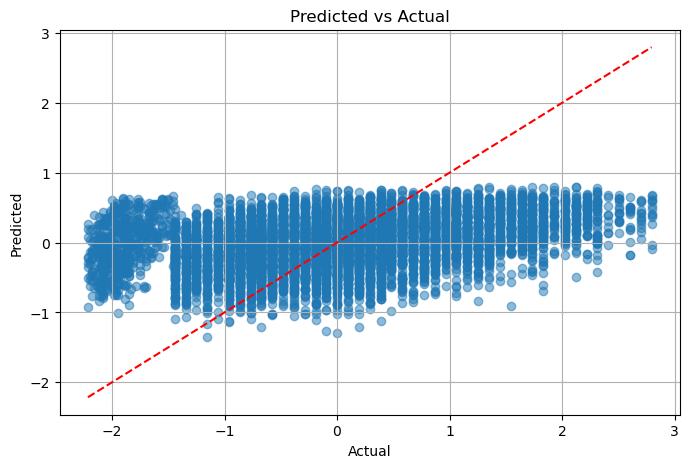

In [25]:
import matplotlib.pyplot as plt

# Example using the best model (choose the one you prefer)
best_model = models['Linear Regression']  # or 'Random Forest'
preds = best_model.predict(X_test)

plt.figure(figsize=(8, 5))
plt.scatter(y_test, preds, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Predicted vs Actual")
plt.grid(True)
plt.show()

In [26]:
import joblib
joblib.dump(best_model, 'best_model.pkl')

['best_model.pkl']

In [27]:
X_train.columns.tolist()

['Store_Latitude',
 'Store_Longitude',
 'Drop_Latitude',
 'Drop_Longitude',
 'Weather',
 'Traffic',
 'Vehicle',
 'Area',
 'Category',
 'distance_km',
 'Hour',
 'DayOfWeek',
 'Order_Time_hour',
 'Order_Time_dayofweek',
 'Pickup_Time_hour',
 'Pickup_Time_dayofweek',
 'duration_minutes']

In [34]:
X = X_train[['Category', 'Area', 'Order_Time_hour', 'Order_Time_dayofweek', 'distance_km']]
y = y_train

model = LinearRegression().fit(X, y)


In [35]:
import joblib
joblib.dump(model, 'model.pkl')

['model.pkl']